# Multivariate

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

Then we download the data base **dat**.

In [3]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Elevations.NF'
elev_nf, head = urllib.request.urlretrieve(url)
target = gl.DbGrid.createFromNF(elev_nf)
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim);

In [4]:
dat.setName("January_temp","Temperature")
unique_neigh = gl.NeighUnique.create()

Statistics

In [5]:
st = dat.statistics(["Elevation", "Temperature"])
st = target.statistics(["Elevation"], title="Target Elevation Mean")

                 MEAN
Elevation       87.974
Temperature      2.815
 Target Elevation Mean   241.152
 

Observations

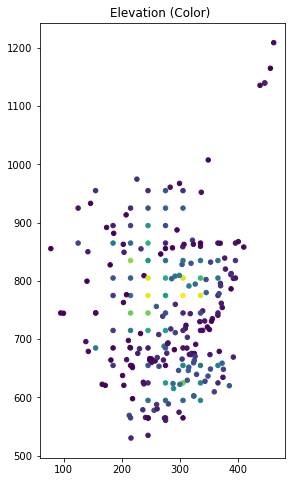

In [6]:
gp.setDefaultGeographic(dims=[8,8])
ax = dat.plot(name_color="Elevation")

Map of the elevations

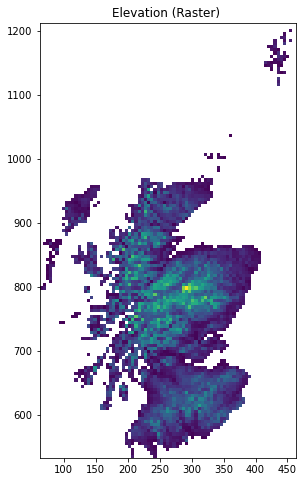

In [7]:
ax = target.plot("Elevation")

Temperature vs. Elevation

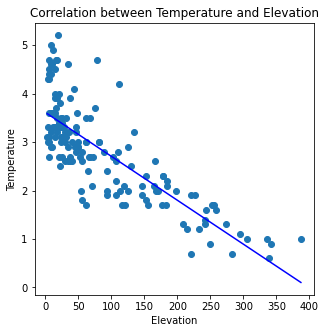

In [8]:
ax = gp.correlation(dat, namex="Elevation", namey="Temperature", asPoint=True, regrLine=True)
ax.decoration(title="Correlation between Temperature and Elevation")

Variograms and Non-stationarity

Directional variograms (N-S and E-W): no drift or with first order global trend

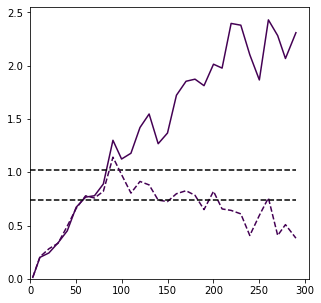

In [9]:
varioparam = gl.VarioParam.createMultiple(ndir=2, npas=30, dpas=10)
vario_raw2dir = gl.Vario(varioparam, dat)
err = vario_raw2dir.compute()

model = gl.Model.create()
model.setDriftIRF(1)
vario_res2dir = gl.Vario(varioparam, dat)
err = vario_res2dir.compute(model=model)

axs = vario_raw2dir.plot()
axs = vario_res2dir.plot(linestyle='dashed')
ax.decoration(title="Temperature (°C)", xlabel = "Distance (km)", ylabel = "Variogram")

Global trend

Find the coefficients of the global regression (first order polynomial)

In [10]:
err = gl.regression(dat, name0="Temperature", mode=2, model=model, verbose=True)


 Linear Regression
 -----------------
 - Calculated on 151 active values
 - Explanatory Variable #1 = 3.521360
 - Explanatory Variable #2 = -0.007466
 - Explanatory Variable #3 = 0.001978
 - Initial variance        = 1.019788
 - Variance of residuals   = 0.735557
 

Modelling Variogram of Raw Data with Anisotropy

In [11]:
fitmod = gl.Model()
err = fitmod.fit(vario_raw2dir,types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC])

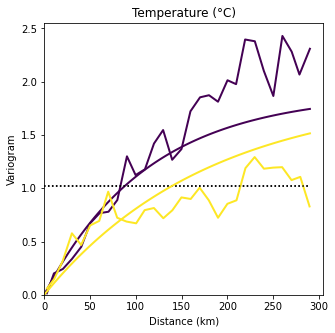

In [12]:
ax = gp.varmod(vario_raw2dir, fitmod, lw=2)
ax.decoration(title="Temperature (°C)", xlabel = "Distance (km)", ylabel = "Variogram")

Ordinary Kriging - Cross-Validation

Perform Cross-validation (using Ordinary Kriging) and calculate the Mean Squared Error.

In [13]:
err = gl.xvalid(dat, fitmod, unique_neigh, namconv=gl.NamingConvention("OK",True,True,False))
st = dat.statistics(["OK.Temperature.*"])

                 MEAN
OK.Temperature.esterr     -0.041
OK.Temperature.stderr     -0.044
 

Ordinary Kriging - Estimation

In [14]:
err = gl.kriging(dat, target, fitmod, unique_neigh, namconv=gl.NamingConvention("OK"))

Graphic representation of Ordinary Kriging estimation

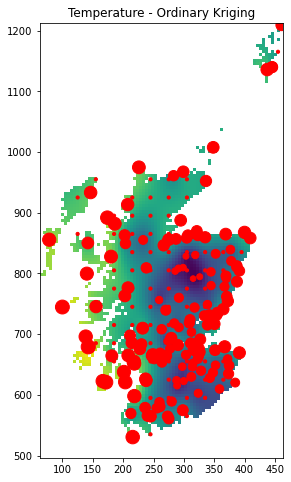

In [15]:
ax = target.plot("OK*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature - Ordinary Kriging")

Statistics on the Ordinary Kriging

In [16]:
st = target.statistics(["OK.Temperature.*"])

                 MEAN
OK.Temperature.estim      2.806
OK.Temperature.stdev      0.460
 

Fitting Variogram of Residuals

In [17]:
fitmodUK = gl.Model()
err = fitmodUK.fit(vario_res2dir,types=[gl.ECov.SPHERICAL],optvar=gl.Option_VarioFit(False,False))

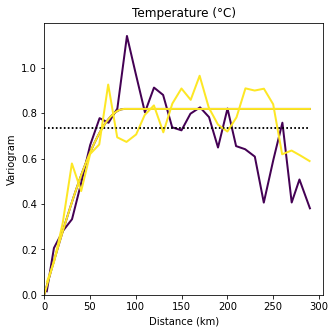

In [18]:
ax = gp.varmod(vario_res2dir, fitmodUK, lw=2)
ax.decoration(title="Temperature (°C)", xlabel = "Distance (km)", ylabel = "Variogram")

Note that the residuals seem isotropic, hence use isotropic option for Fitting.

Universal Kriging - Cross-Validation

Perform Cross-validation (using Universal Kriging) and calculate the Mean Squared Error.

In [19]:
err = gl.xvalid(dat, fitmodUK, unique_neigh, namconv=gl.NamingConvention("UK",True,True,False))
st = dat.statistics(["UK.Temperature.*"])

                 MEAN
UK.Temperature.esterr     -0.352
UK.Temperature.stderr     -0.499
 

Universal Kriging - Estimation

In [20]:
err = gl.kriging(dat, target, fitmodUK, unique_neigh, namconv=gl.NamingConvention("UK"))

Graphic representation

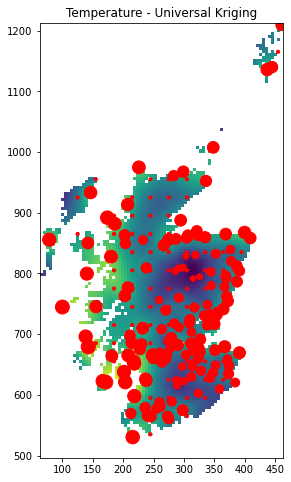

In [21]:
ax = target.plot("UK*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature - Universal Kriging")

Statistics on Universal Kriging

In [22]:
st = target.statistics(["UK.Temperature.*"])

                 MEAN
UK.Temperature.estim      2.514
UK.Temperature.stdev      0.482
 

Comparing Ordinary and Universal Krigings

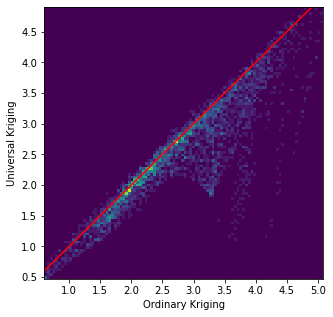

In [23]:
ax = gp.correlation(target, namex="OK*estim", namey="UK*estim", bissLine=True, bins=100)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Universal Kriging")

Comparing Temperature and Elevation

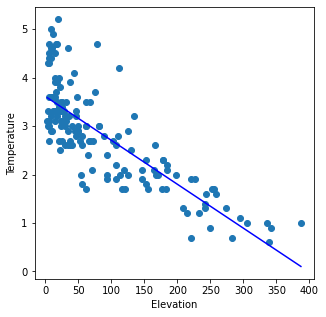

In [24]:
ax = gp.correlation(dat, namex="Elevation", namey="Temperature",regrLine=True,asPoint=True)

Average of Elevations of all data and average of Elevations of meteorological stations

In [25]:
st = dat.statistics(["Elevation", "Temperature"])

                 MEAN
Elevation       87.974
Temperature      2.815
 

Average of Elevations when Temperatures are defined

In [26]:
sel = dat["Temperature"]
uid = dat.addSelection(~np.isnan(sel),"Temperature defined")
st = dat.statistics(["Elevation", "Temperature"])

                 MEAN
Elevation       87.974
Temperature      2.815
 

Bivariate Modelling

In [27]:
dat.deleteColumn("Temperature defined")
dat.setLocators(["Temperature", "Elevation"], gl.ELoc.Z)

Bivariate Modelling

In [28]:
varioexp2var = gl.Vario.create(varioparam, dat)
err = varioexp2var.compute()
fitmod2var = gl.Model()
err = fitmod2var.fit(varioexp2var,
                     types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC])


Model characteristics
Space dimension              = 2
Number of variable(s)        = 2
Number of basic structure(s) = 3
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill matrix:
               [,  0]    [,  1]
     [  0,]     0.000     0.287
     [  1,]     0.287  6611.646
Exponential
- Sill matrix:
               [,  0]    [,  1]
     [  0,]     0.378   -98.337
     [  1,]   -98.337 25589.361
- Ranges       =    161.900    87.486
- Theo. Ranges =     54.044    29.204
Cubic
- Sill matrix:
               [,  0]    [,  1]
     [  0,]     1.723    21.469
     [  1,]    21.469   267.462
- Ranges       =   5804.192    50.968
Total Sill
               [,  0]    [,  1]
     [  0,]     2.101   -76.581
     [  1,]   -76.581 32468.469

 

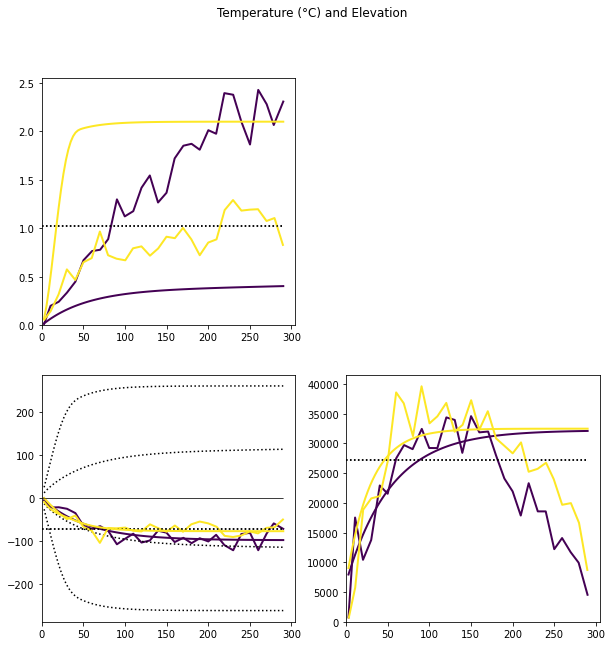

In [37]:
fitmod2var.display()
ax = gp.varmod(varioexp2var, fitmod2var, lw=2)
gp.decoration(ax,title="Temperature (°C) and Elevation")

Cokriging with elevation - Cross-Validation

Most of the processes are more time-consuming in Unique Neighborhood.
We create a small neighborhood for demonstration.

In [30]:
moving_neigh = gl.NeighMoving.create(radius = 1000, nmaxi = 10)

Perform Cross-validation (Bivariate Model) and calculate the Mean Squared Error.

In [31]:
err = gl.xvalid(dat, fitmod2var, moving_neigh, namconv=gl.NamingConvention("COK",True,True,False))
st = dat.statistics(["COK.Temperature.*"])

                 MEAN
COK.Temperature.esterr     -0.407
COK.Temperature.stderr     -0.515
 

Cokriging with elevation - Estimate

In [32]:
err = gl.kriging(dat, target, fitmod2var, unique_neigh, namconv=gl.NamingConvention("COK"))

Graphic representation

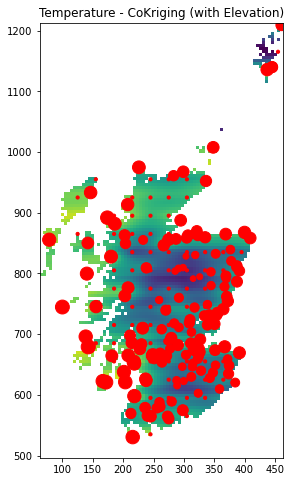

In [33]:
ax = target.plot("COK.T*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature - CoKriging (with Elevation)")

Statistics

In [34]:
st = target.statistics(["COK.Temperature.*"])

                 MEAN
COK.Temperature.estim      2.553
COK.Temperature.stdev      0.388
 

Comparing Kriging and CoKriging

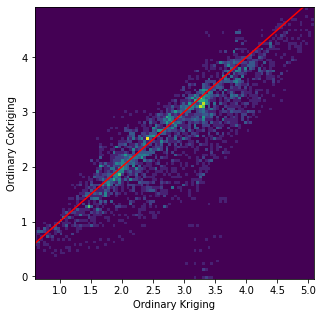

In [35]:
ax = gp.correlation(target, namex="OK.T*estim", namey="COK.T*estim", bissLine=True, bins=100)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Ordinary CoKriging")

Note that CoKriging produces estimates which are mostly larger than Kriging estimates.

Kriging the residuals

$$
Z_2(s)=b + a Z_1(s) + R(s)
$$

A first call to the regression function is done in order to retreive the coefficients of the regression

In [36]:
regr = gl.regression(dat, "Temperature", ["Elevation"], 0, flagCste=True, verbose=True)
b = regr.coeffs[0]
a = regr.coeffs[1]


 Linear Regression
 -----------------
 - Calculated on 151 active values
 - Constant term           = 3.611970
 - Explanatory Variable #1 = -0.009064
 - Initial variance        = 1.019788
 - Variance of residuals   = 0.363298
 

We calculate the Residuals and provide some statistics

In [ ]:
err = gl.dbRegression(dat, "Temperature", ["Elevation"],
                     namconv = gl.NamingConvention("Regr",True,True,False))
st = dat.statistics(["Regr*"])

In [ ]:
ax = gp.correlation(dat, namex="Elevation", namey="Regr*",regrLine=True,asPoint=True)

Kriging the residuals - Variogram of the residual

In [ ]:
dat.setLocator("Regr*",gl.ELoc.Z, cleanSameLocator=True)
varioexpR = gl.Vario(varioparam, dat)
err = varioexpR.compute()
fitmodR = gl.Model()
err = fitmodR.fit(varioexpR,types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.ORDER1_GC])

In [ ]:
ax = gp.varmod(varioexpR, fitmodR, lw=2)
ax.decoration(title="Temperature Residual",xlabel = "Distance (km)", ylabel = "Variogram")

Kriging the residuals

In [ ]:
err = gl.kriging(dat, target, fitmodR, unique_neigh, namconv=gl.NamingConvention("ROK"))

In [ ]:
ax = target.plot("ROK.Regr*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature Residuals")

Kriging the residuals - Computing the estimate

$$
Z_2^{\star} = b + a Z_1(s) + R(s)^{OK}
$$


In [ ]:
ROK_estim = target["ROK.Regr*estim"] + b + a * target["Elevation"]
uid = target.addColumns(ROK_estim,"KR.Temperature.estim")

In [ ]:
ax = target.plot("KR.T*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature with Residuals")

Correlation between Ordinary Kriging and CoKriging

In [ ]:
ax = gp.correlation(target, namex="OK.T*estim", namey="COK.T*estim", bissLine=True, bins=100, flagSameAxes=True)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Ordinary CoKriging")

Correlation between Ordinary Kriging and Kriging withResiduals

In [ ]:
ax = gp.correlation(target, namex="OK.T*estim", namey="KR.T*estim", bissLine=True, bins=100, flagSameAxes=True)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Kriging with Residuals")

Some statistics for comparison

In [ ]:
st = target.statistics(["OK.T*estim", "UK.T*estim", "COK.T*estim", "KR.T*estim"])

## Using Elevation Map as External Drift

Preparing the data bases

In [ ]:
dat.setLocator("Temperature",gl.ELoc.Z,cleanSameLocator=True)
dat.setLocator("Elevation",gl.ELoc.F,cleanSameLocator=True)

In [ ]:
varioKED = gl.Vario(varioparam, dat)

model = gl.Model.create()
model.setDriftIRF(order=0, nfex=1)
err = varioKED.compute(model=model)

Comparing the Experimental variograms

In [ ]:
axs = vario_raw2dir.plot()
axs = varioKED.plot(linestyle='dashed')

Model of Residuals (External Drift)

In [ ]:
modelKED = gl.Model()
err = modelKED.fit(varioKED,types=[gl.ECov.NUGGET, gl.ECov.CUBIC, gl.ECov.GAUSSIAN])
modelKED.setDriftIRF(order = 0, nfex = 1)

Cross-Validation with External Drift

In [ ]:
err = gl.xvalid(dat, modelKED, unique_neigh, namconv=gl.NamingConvention("KED",True,True,False))
st = dat.statistics(["KED.Temperature.*"])

Kriging with External Drift

In [ ]:
err = gl.kriging(dat, target, modelKED, unique_neigh, namconv=gl.NamingConvention("KED"))

Graphic representation

In [ ]:
ax = target.plot("KED.T*estim")
ax = dat.plot(name_size="Temperature")
ax.decoration(title="Temperature with External Drift")

Statistics on Kriging with Elevation as External Drift

In [ ]:
st = target.statistics(["KED.T*"])

Comparing Ordinary Kriging and Kriging with External Drift

In [ ]:
ax = gp.correlation(target, namex="OK.T*estim", namey="KED.T*estim", bissLine=True, bins=100, flagSameAxes=True)
ax.decoration(xlabel="Ordinary Kriging",ylabel="Kriging with External Drift")

Note that negative Estimates are present when using External Drift.

## Summary of Cross-validation scores

Statistics on the cross-validation Mean Squared Errors (for Temperature)

In [ ]:
st = dat.statistics(["*T*.esterr"])

Statistics on the various estimates

In [ ]:
st = target.statistics(["*.Temperature.estim"])

Statistics on the various standard deviation of estimation errors

In [ ]:
st = target.statistics(["*.Temperature.stdev"])